# Data 330 Applied Time Series Analysis - Lab 3

Katherine Lannen

last edited: 2021-05-07

***

## 1. Required Packages

**tswge**$^{[1]}$ and **tuneR**$^{[2]}$ need to be installed to successfully run the entire notebook. The first code block below will install tswge if you haven't done so before and the second code block will load the package into your session. 

**Note:** While not a package this notebook does require you to have the audio file in the following file path "/content/Synapsis - Wonderland.mp3", you can download the original file for yourself in the Free Music Archive$^{[5]}$.

In [1]:
install.packages("tswge")
install.packages("tuneR", dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library("tswge")
library("tuneR")

## 2. Introduction  

This lab explores the concept of filters, what they are and some of the various types. This lab will also go through the process of implementing and using filters and identify some of their impact on the song Wonderland by Synapsis  which was retrieved from the Free Music Archive$^{[5]}$. 

### 2.1 Filters

Filters add additional contraints to or modifications of the original data. Filtering could involve making a subset from the initial data but in general filters strain something away and/or separate/combine data into different categories, labels, or sections. Filters are commonly used in data science as a tool to automatically take in certain criteria and input and apply a process that produces an altered output that is easier to handle, more relevant to the purpose/scope/topic of the project at hand, and deal with the size and computational cost and complexity at scale.

Filters can be thought of as a set of rules or conditions that are then applied to the dataset and depending on what the action it indicates to take the output is then processed. Filters are critical to analysis on large datasets like time series where the scope and scale is large and processing all of the data individually can take away from the focus of the analysis and increase the computational cost/power of said analysis. It can be said that filtering ones data (removing outliers, grouping or averaging, subsetting to relevant categories, etc.) is usually the first step taken in the process after the format of the data is reviewed. 



### 2.2 Filter Examples

Filters and the idea behind it can be found everywhere in the world and in data science. Instagram and Snapchat filters are in fact filters as they do take in inputs and alter them to create a desired alternate output. Parental controls where parents can define what input/output is or is not accepted and add additional checks to increase the complexity of what and when certain things are available are filters. Another example of a filter is in neural networks when an image is taken in the image's matrix of pixel values is separated and modified by having a filter of a certain size scan over said image and compile data, reducing the dimensions of the output which is being fed into the next step of the network. Finally, the last example that I will be stating in this section is that the Three point moving average. In the three point moving average, alters aggregate data, taking in more input and reducing it to a smaller size while retaining values. In this notebook butterworth is a linear filter that will be used in section 3.1, this filter is described in slightly more detail there.

## 3. Methods

### 3.1 Loading the Data

As mentioned in the introduction, this notebook will be using the song Wonderland by Synapsis which is an Electronic song retrieved from the Free Music Archive$^{[5]}$ to apply filters to the frequency domain and identify the impact. This mp3 audio file is stored in a temporary file with the following path, "/content/Synapsis - Wonderland.mp3". 


To load in this data, the tuneR$^{[2]}$ package was used along with the implementation given in the Analyzing Audio Files notebook$^{[4]}$. Most of the comments are based off of this notebook as well. 

To better visualize the data that is being read in, the tone audio of the file is shown by plotting the pressure values against the time axis limiting the number of samples shown due to the overall number of samples in the file.

In [3]:
# Load audio file into the notebook
mp3 <- readMP3("/content/Synapsis - Wonderland.mp3")
str(mp3)

Formal class 'Wave' [package "tuneR"] with 6 slots
  ..@ left     : int [1:10442880] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ right    : int [1:10442880] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ stereo   : logi TRUE
  ..@ samp.rate: num 44100
  ..@ bit      : num 16
  ..@ pcm      : logi TRUE


In [4]:
# Check audio length (convert seconds to minutes)
num_samples <- length(mp3@left)
print(num_samples / mp3@samp.rate / 60)

# Pull only the left audio channel
s1 <- mp3@left

# Map amplitudes on range from -1 to 1.
m1 <- s1 / 2^(mp3@bit - 1)

# Create an array containing the time points of the sound
time <- (0:(num_samples - 1)) / mp3@samp.rate

[1] 3.946667


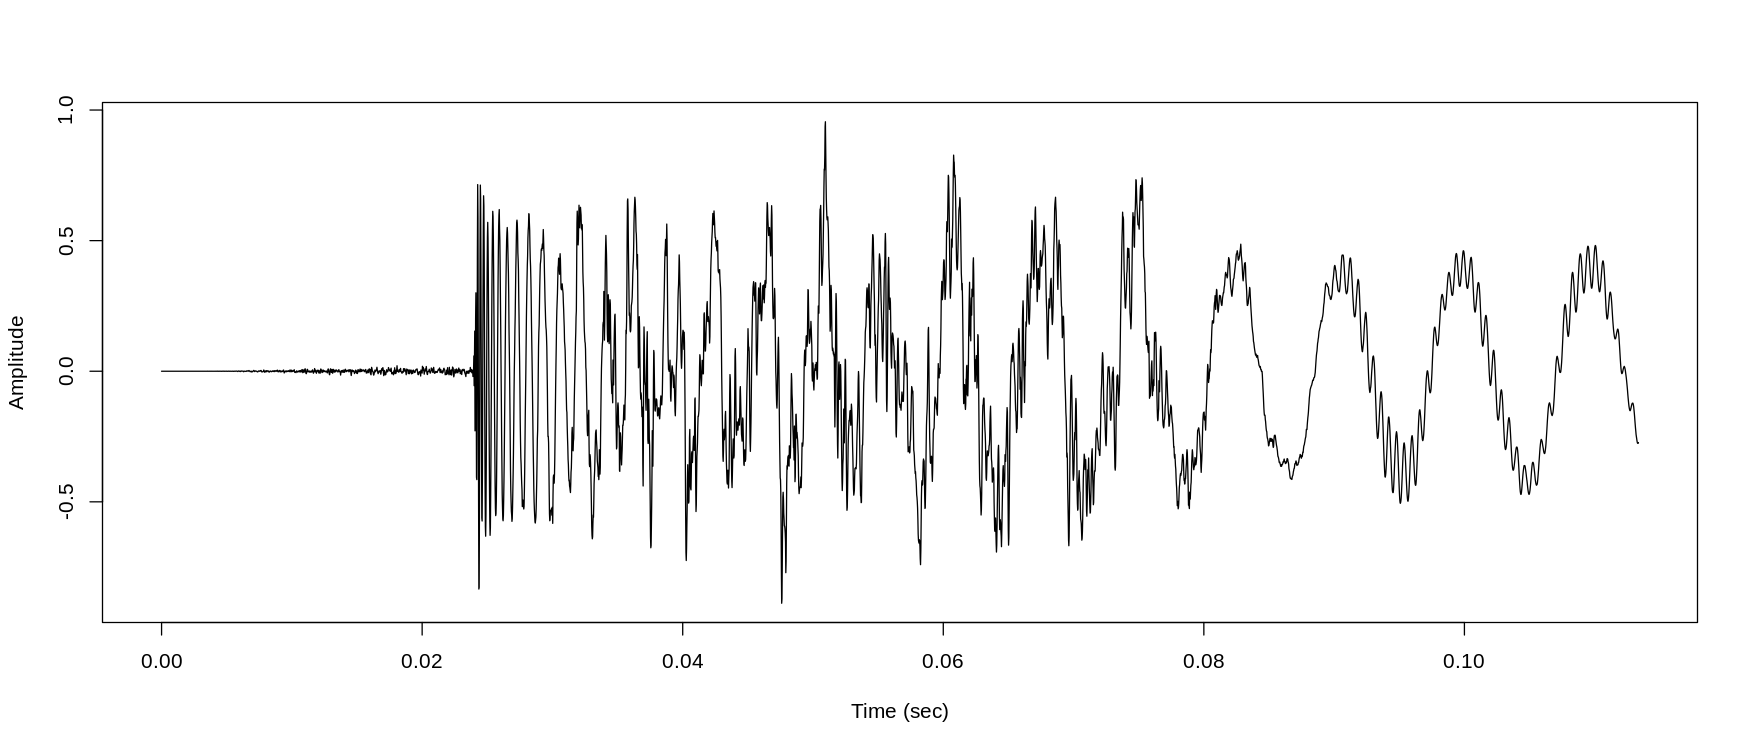

In [10]:
# Plot the tone of the audio file by plotting the pressure values against the time axis
# Because there are 10442880 samples, only the 5000 will be shown in the figure

m1_filt <- m1[1:5000]
time_filt <- time[1:5000]

options(repr.plot.width=14, repr.plot.height=6, repr.plot.res = 125)
plot(time_filt, m1_filt, type='l', col='black', xlab='Time (sec)', ylab='Amplitude')

### 3.2 Summary Stats of Data

The song Wonderland by Synapsis has a sampling rate of 44100 Hz and a bit rate of 329 kb/s. There are 10442880 samples in total and the overall length of the song is 3:56. The audio file also has a 16-bit depth. This means that the sound pressure values are mapped to integer values that can range from -2^15 to (2^15)-1$^{[4]}$.

In [6]:
cat(paste("Bit Depth:",mp3@bit,"\n"))
cat(paste("Sampling Rate:",mp3@samp.rate,"Hz\n"))
cat(paste("Number of Samples:",num_samples,"\n"))

Bit Depth: 16 
Sampling Rate: 44100 Hz
Number of Samples: 10442880 


### 3.3 Filters

Please refer to sections 2.1 and 2.2 for more information about what filters are, why they are important, and additional examples of their uses. In the section below we will be using the data that was loaded in 3.1 and applying a couple of different filters on it. 

When applying these filters, the main method we will be using is butterworth which is a function implemented in the twsge package. Butterworth is a common linear filter used by scientists and engineers and can be used in several different types of processes. This filter takes in different cutoff points for frequencies and has four main types: low pass, high pass, band pass, and band stop. The order of the Butterworth Filter ($N$) is selected by the user where higher orders have more severe impacts on frequencies that are filtered out and low orders have low impact on spectral density. For the purpose of this notebook, three types of filters will be used. These filters are low pass, high pass, and band pass filters. After referring to the raw data's realization, autocorrelation and periodogram (section 4.1 in this notebook), the cutoff values for the filters were decided. The cutoff for the low pass filter was decided to be 0.01, the cutoff for the high pass filter was decided to be 0.06, and finally the band pass filters cutoff was determined to be the joint of the two cutoffs for the previous filters. To see the filtered data's realization, autocorrelation and periodogram for each filter please refer to 4.2, 4.3, and 4.4 respectively.

In [16]:
low_pass <- butterworth.wge(m1_filt, 3, type = "low", cutoff = .01, plot = FALSE)

In [18]:
high_pass <- butterworth.wge(m1_filt, 3, type = "high", cutoff = .06, plot = FALSE)

In [19]:
band_pass <- butterworth.wge(m1_filt, 3, type = "pass", cutoff = c(0.01,0.06), plot = FALSE)

## 4. Results

### 4.1 Raw Frequency Data - Realization, Autocorrelation, and Periodogram

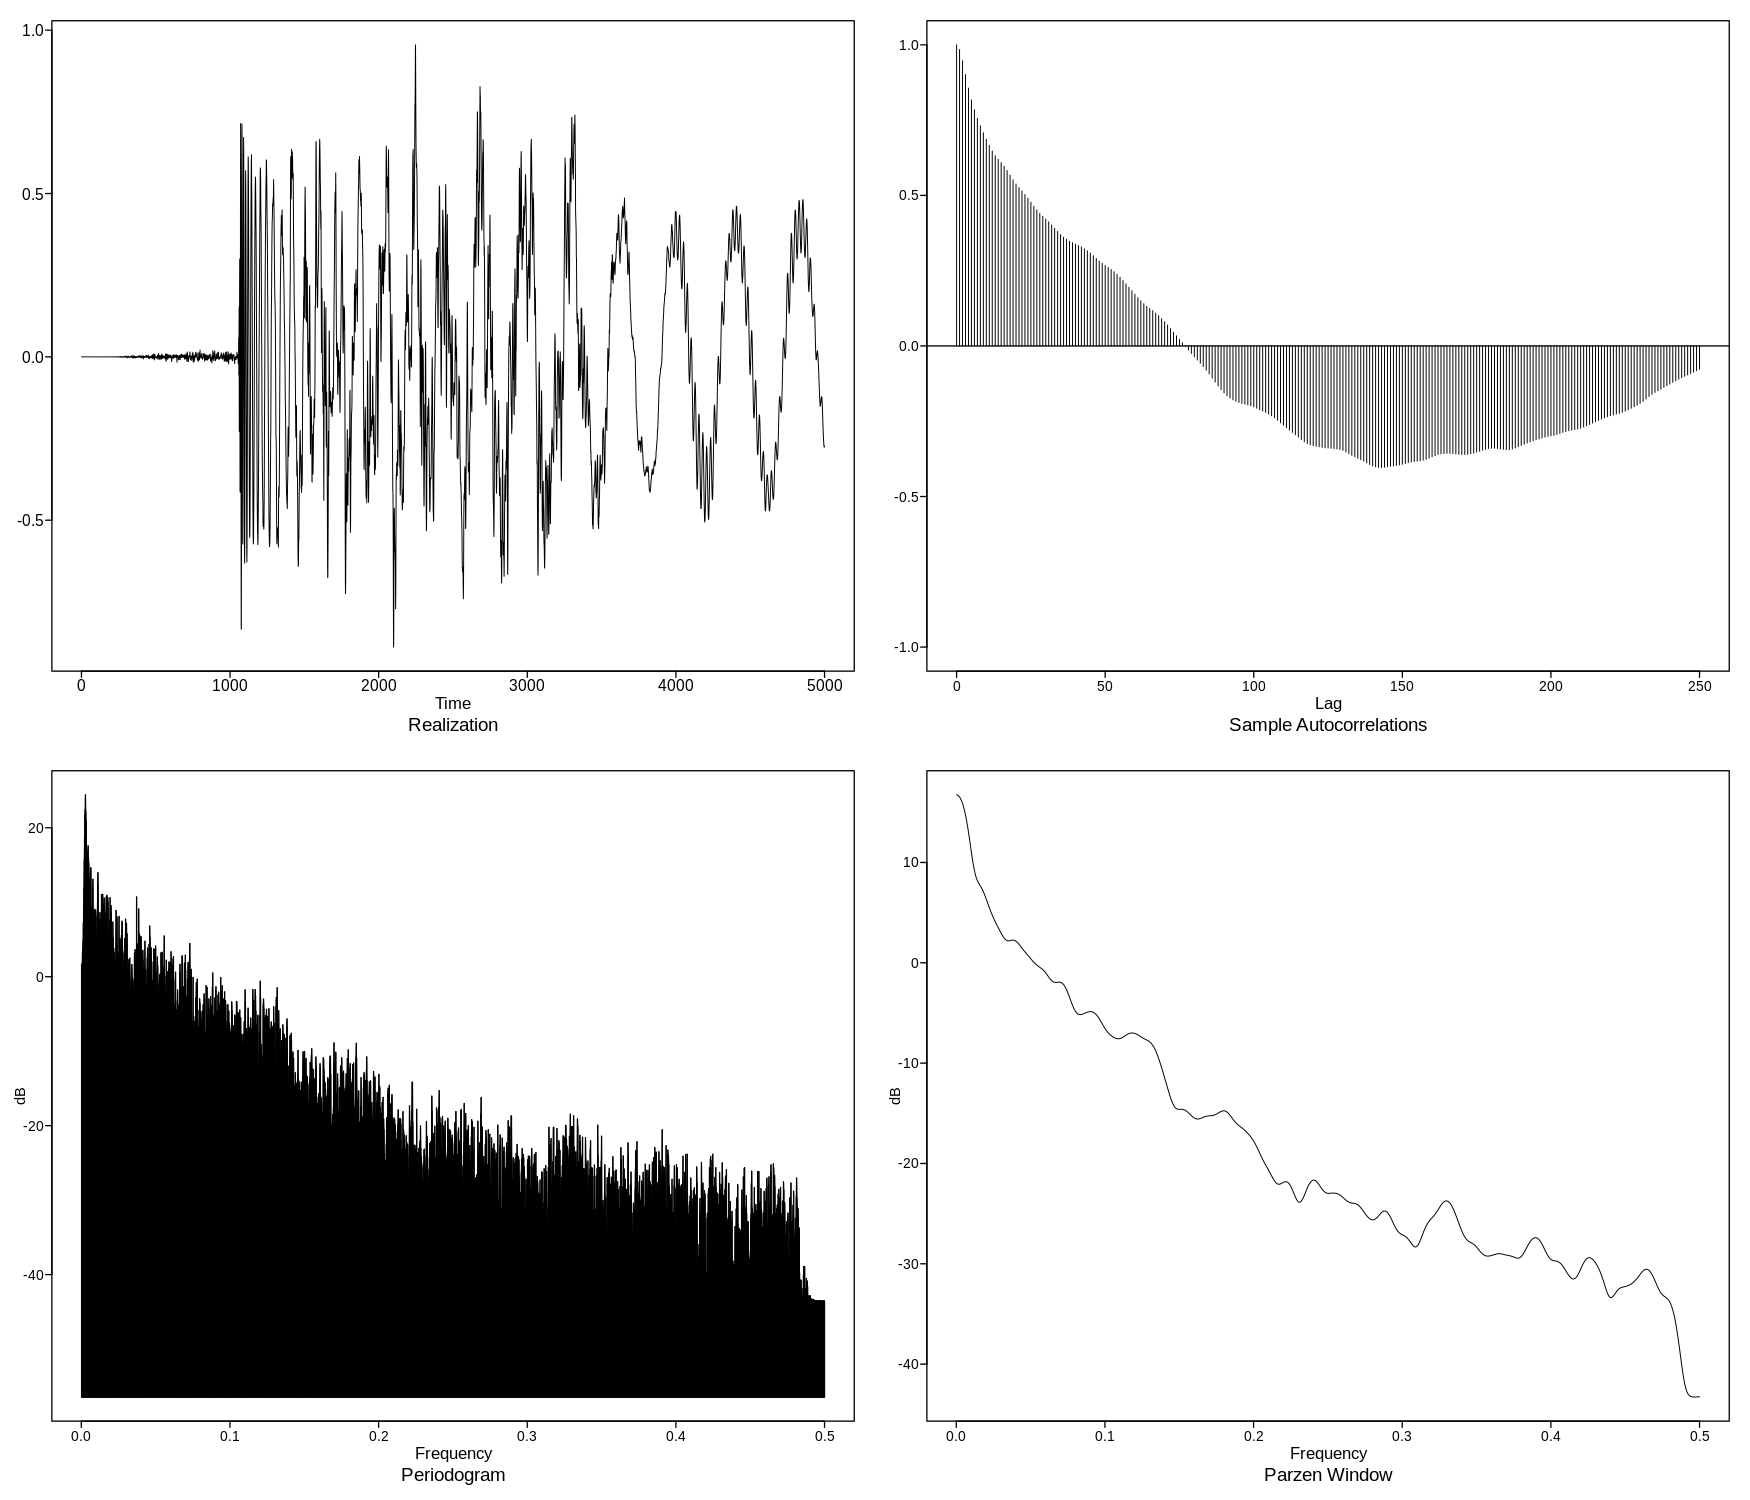

In [13]:
options(repr.plot.width=14, repr.plot.height=12, repr.plot.res = 125)
par(cex.main =  2, cex.lab = 1.5, cex.axis = 1.5, cex.sub = 1.25)
orig.plots <- plotts.sample.wge(m1_filt, lag.max = 250)

### 4.2 Low Pass Filter - Realization, Autocorrelation, and Periodogram

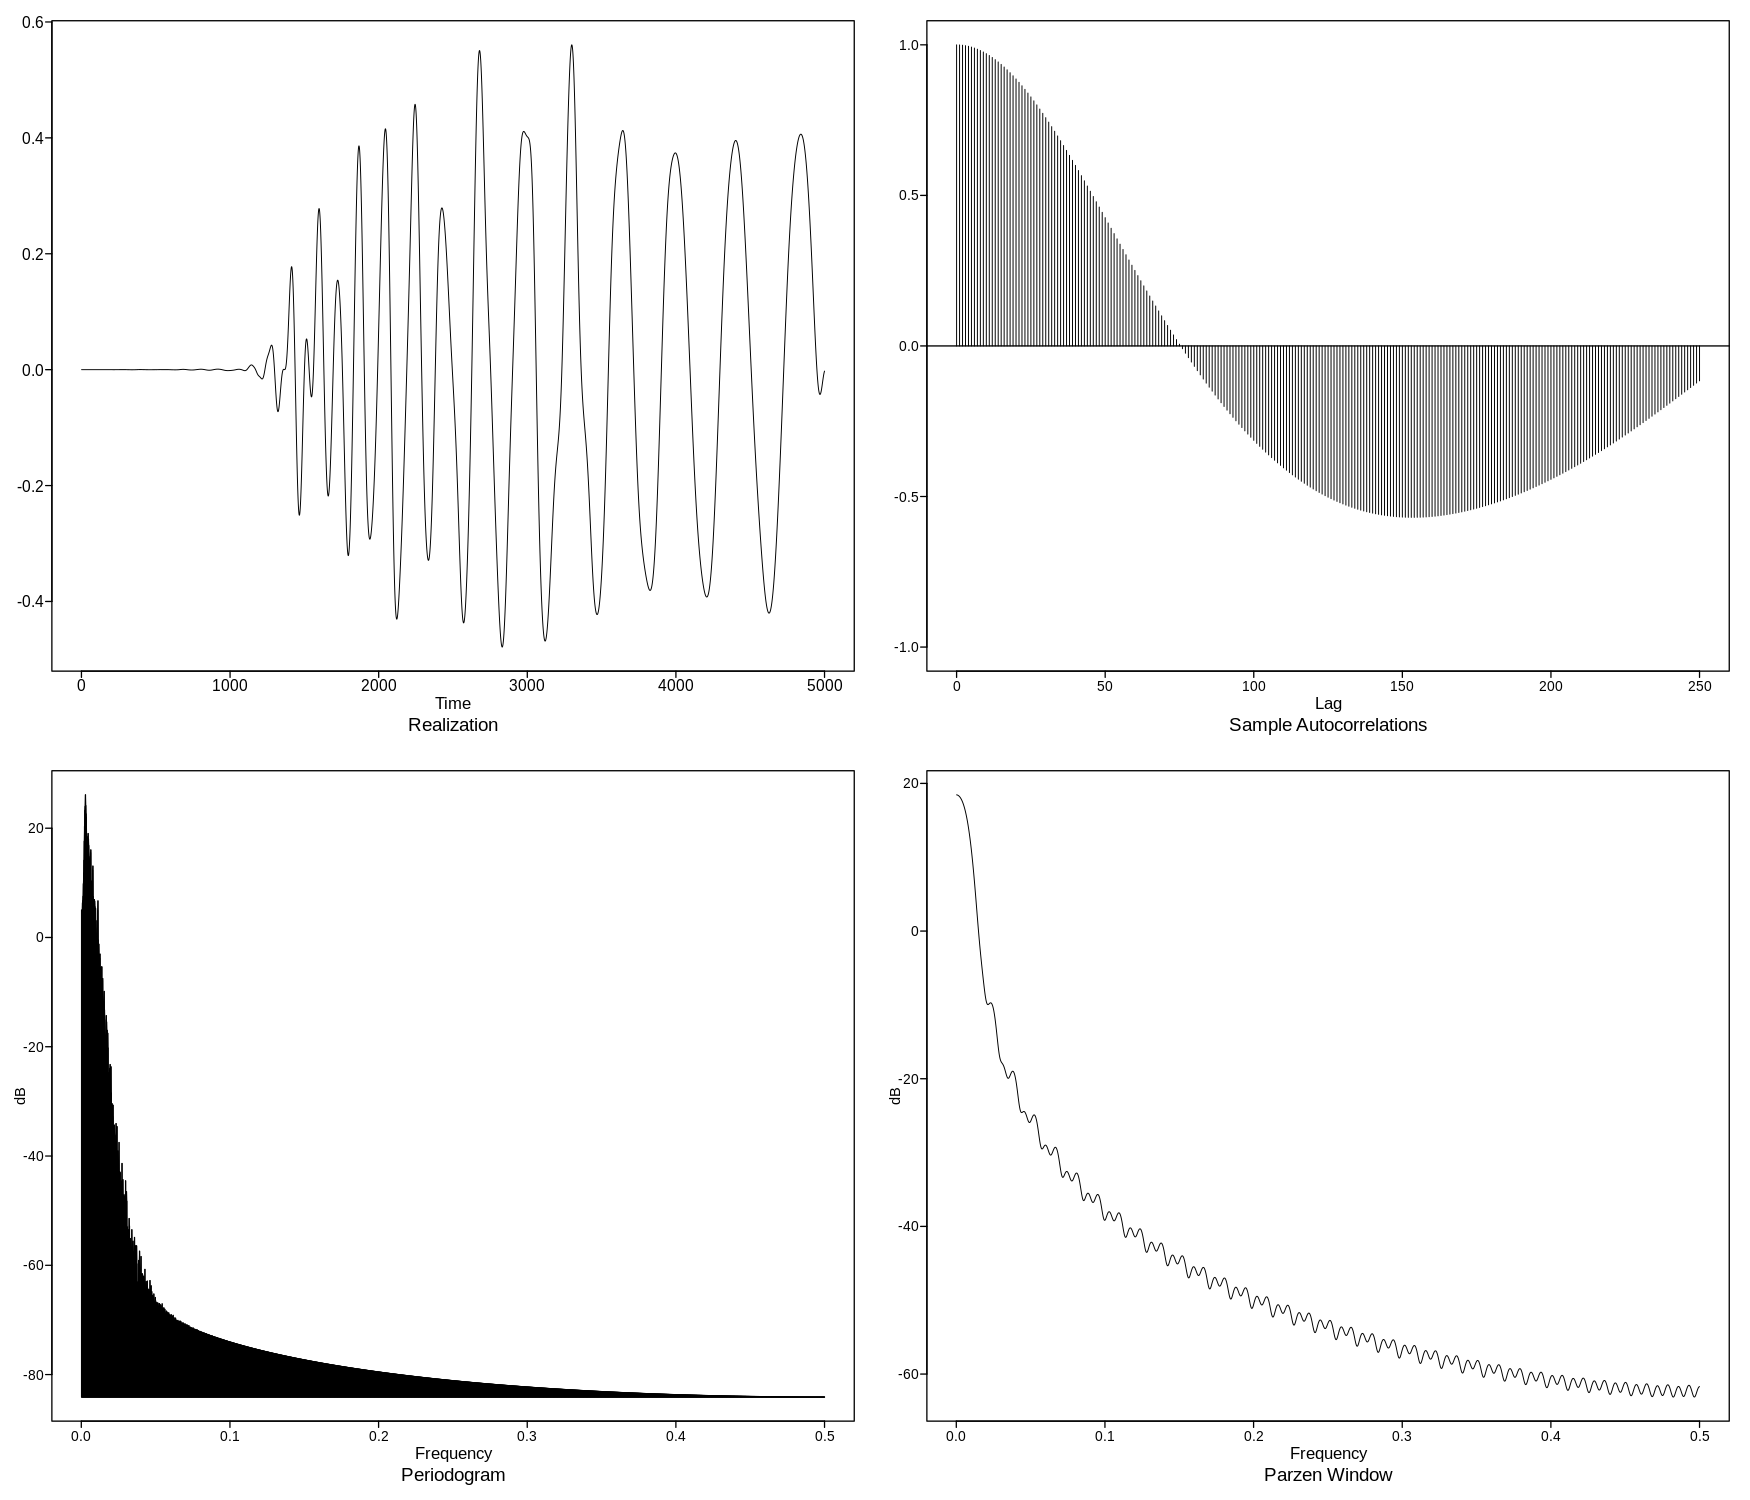

In [21]:
options(repr.plot.width=14, repr.plot.height=12, repr.plot.res = 125)
par(cex.main =  2, cex.lab = 1.5, cex.axis = 1.5, cex.sub = 1.25)
orig.plots <- plotts.sample.wge(low_pass$x.filt, lag.max = 250)

### 4.3 High Pass Filter - Realization, Autocorrelation, and Periodogram

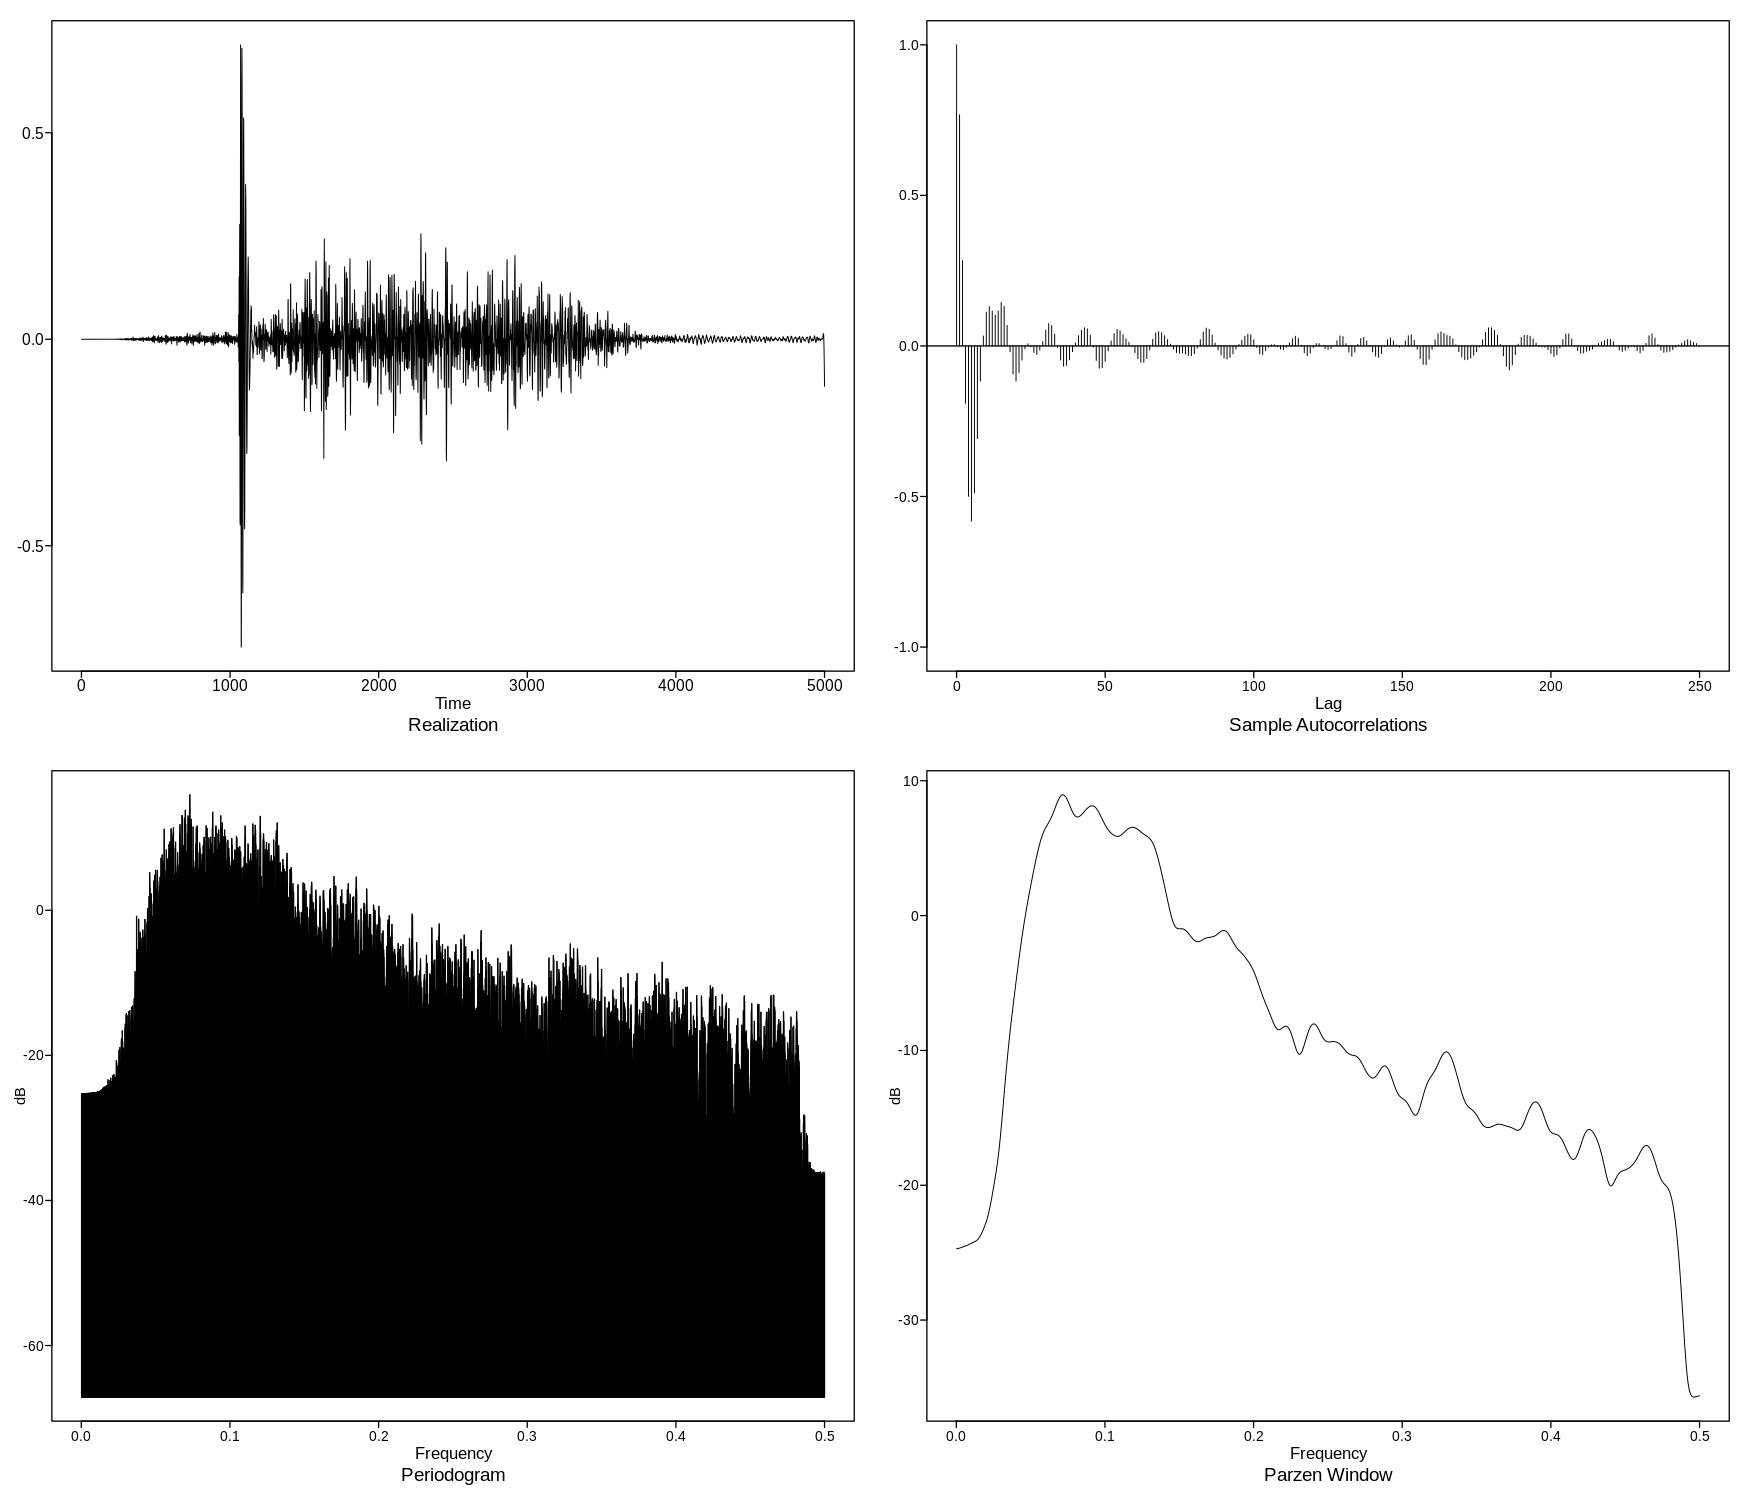

In [22]:
options(repr.plot.width=14, repr.plot.height=12, repr.plot.res = 125)
par(cex.main =  2, cex.lab = 1.5, cex.axis = 1.5, cex.sub = 1.25)
orig.plots <- plotts.sample.wge(high_pass$x.filt, lag.max = 250)

### 4.4 Band Pass Filter - Realization, Autocorrelation, and Periodogram

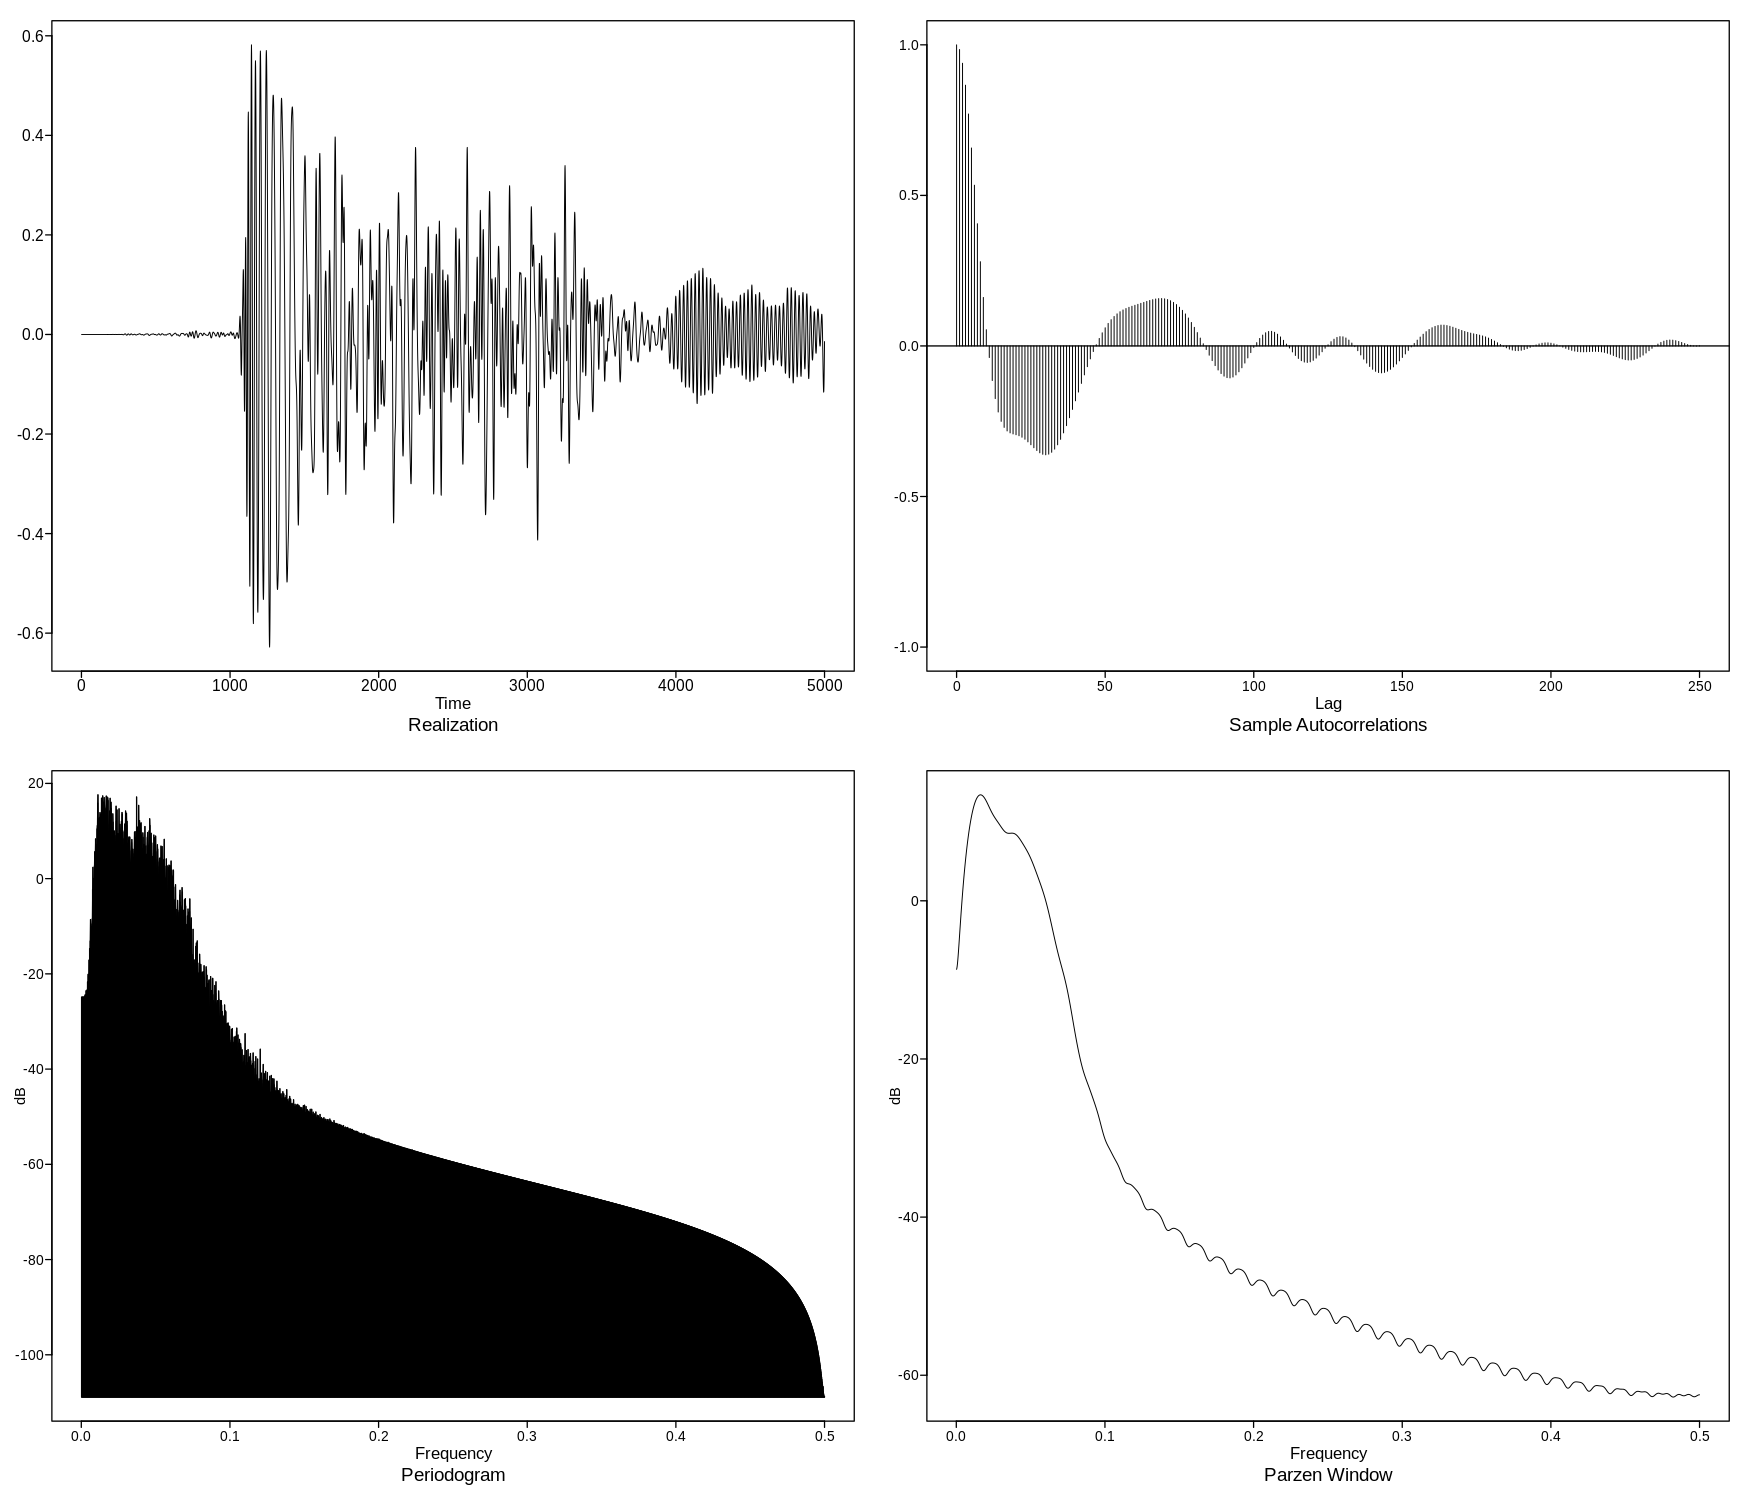

In [23]:
options(repr.plot.width=14, repr.plot.height=12, repr.plot.res = 125)
par(cex.main =  2, cex.lab = 1.5, cex.axis = 1.5, cex.sub = 1.25)
orig.plots <- plotts.sample.wge(band_pass$x.filt, lag.max = 250)

## 5. Discussion and Conclusions 

The realization of the raw data seemed to have no clear period with any cycles that did appear not being consistent and with drastically alternating magnitudes. In order to determine the frequencies of these different sections three filters were applied to the raw data. These being low pass, high pass, and band pass filters. The cutoff values for the filters were decided. The cutoff for the low pass filter was decided to be 0.01, the cutoff for the high pass filter was decided to be 0.06, and finally the band pass filters cutoff was determined to be the joint of the two cutoffs for the previous filters. To see the filtered data's realization, autocorrelation and periodogram for each filter please refer to 4.2, 4.3, and 4.4 respectively.

Unlike the raw data, the data after the low pass filter seemed to have more periodic behavior and strong autocorrelations across lag periods. This behavior did not appear until around the 1100 timestamp and the magnitdue and length of the period seems to be increasing over time especially the magnitude of the cycles increasing from the starting point till around the 3100 timestamp. 

The high pass filtered data shows a really large spike in around the 1000 timestamp, other than that the data itself is pretty similar but also does not seem to have periodic behavior and the dominant frequency of this filter is roughly around 0.7 or so which I believe occurs roughly around the same time as the large spike. Interestingly the autocorrelation decreases for a while across the lags but around lag 150 or so, the autocorrelation increases once again. This high pass filter does help with the visualization of the different components/sections/instraments of the song that is being analyzed. 

Finally the band pass filter results shows some what of a periodic behavior but not completely. It contains a trend when the frequency is decreasing in the parzen window where over time the same sort of period can be seen. The magnitude of these curves varies wuite a lot. 

The filters helped give another perspective on the audio data and gave ideas on areas that can be further explored. This notebook shows this through the different visualizations which indicate certain groups of various noises in which once again different parts can be studied.

## 6. References 

1. Wayne Woodward (2016). tswge: Applied Time Series Analysis. R package version 1.0.0. https://CRAN.R-project.org/package=tswge
2. Uwe Ligges (2018). tuneR: Analysis of Music and Speech. R package version 1.3.3 https://cran.r-project.org/web/packages/tuneR/index.html
3. Davis, T. (2021). Applied Time Series Analysis: Course Notebook - Student Copy Lesson 3 [ipynb file]. William & Mary, Williamsburg VA. Retrieved from https://colab.research.google.com/drive/1qIdpd_8WFct9zBZ5uwO_Bcg-F3svu0KJ?usp=sharing.
4. Davis, T. (2021). Applied Time Series Analysis: Code Snippets - Analyzing Audio Files [ipynb file]. William & Mary, Williamsburg VA. Retrieved from https://colab.research.google.com/drive/1IuULZkusjNlO-LMrPhNfiq3UGKWauDCi?usp=sharing.
5. Synapsis. “Wonderland.” Goan Psynapsia, 2018, 04. Free Music Archive, https://freemusicarchive.org/music/Synapsis/Goan_Psynapsia/04_Wonderland


